In [2]:
import os
import numpy as np
import pandas as pd
from glob import glob
from datetime import datetime
import scipy as sp
import scipy.optimize as op
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
from scipy.interpolate import interp1d
import seaborn as sns
%matplotlib inline

In [3]:
# define ticks
def set_ticks(ax, xMaj, yMaj):
    ax.xaxis.set_major_locator(MultipleLocator(xMaj))
    ax.yaxis.set_major_locator(MultipleLocator(yMaj))
    ax.minorticks_on()
    ax.tick_params(which='major', width=1.0, length=8, direction='in', labelsize=14)
    ax.tick_params(which='minor', width=1.0, length=4, direction='in', labelsize=14)
    ax.yaxis.get_offset_text().set_fontsize(14)
    ax.xaxis.get_offset_text().set_fontsize(14)


In [85]:
def ang(theta, A):
    '''
        Angular distribution formula 
    '''
    return(A * np.cos(theta) * np.cos(theta))


def exp_pdf(t, a_m, r, tau_p, tau_m, b):
    a_p = r * a_m
    exp_p = a_p * np.exp(-t/tau_p)
    exp_m = a_m * np.exp(-t/tau_m)
    return exp_p + exp_m + b 


def exp(t, A, tau):
    f = A * np.exp(-t/tau)
    return f


def inv_cdf(y, tau):
    t = - tau*(np.log(1-y))
    return t


def angular(theta):
    f = np.cos(theta) * np.cos(theta) * np.cos(theta) * np.sin(theta)
    return f

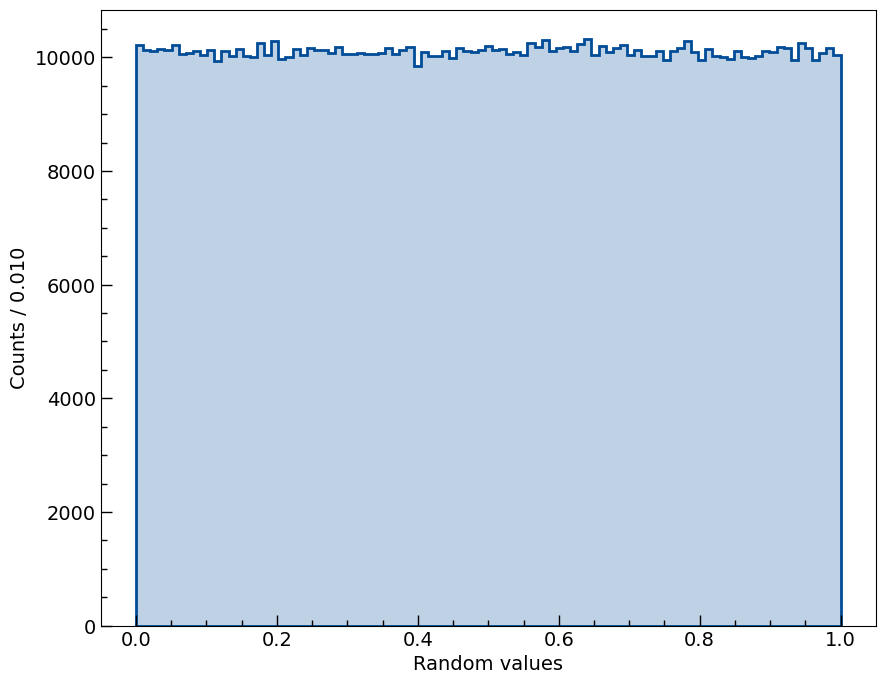

In [40]:
# Generate N random numbers in [0,1] and fill an histogram 

N = 10**6

unif_samples = np.random.uniform(size=N)

fig, ax = plt.subplots(figsize=(10,8))

nbins = np.linspace(0,1,100)

# plot histogram
n, bins , _ = ax.hist(unif_samples, bins=nbins, histtype='stepfilled',fc='#BFD2E5', ec = '#004C97', lw=2, alpha=1, label="Spectrum", align = 'mid')

# array of bin centers
x = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins) - 1)])

# set Poisson uncertainty on each bin   
poisson_err =  np.sqrt(n)  

# bin width 
binwidth = bins[1] - bins[0]

# labels
ax.set_xlabel("Random values", fontsize=14)
ax.set_ylabel("Counts / %1.3f" %binwidth, fontsize=14)

# ticks
set_ticks(ax, 0.2, 2000)

plt.show()


(array([ 2.,  9., 15., 15., 18., 15., 14.,  4.,  6.,  1.]),
 array([ 9892. ,  9938.1,  9984.2, 10030.3, 10076.4, 10122.5, 10168.6,
        10214.7, 10260.8, 10306.9, 10353. ]),
 <BarContainer object of 10 artists>)

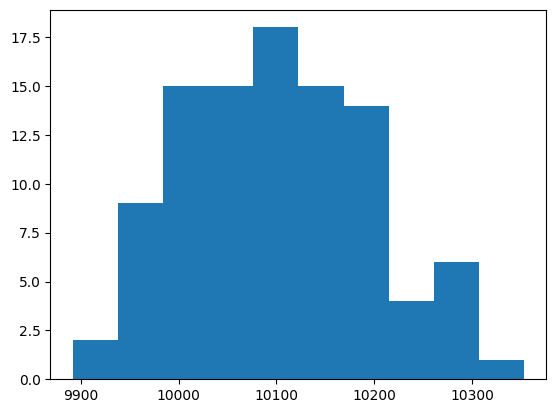

In [38]:
plt.hist(n, bins = 10)

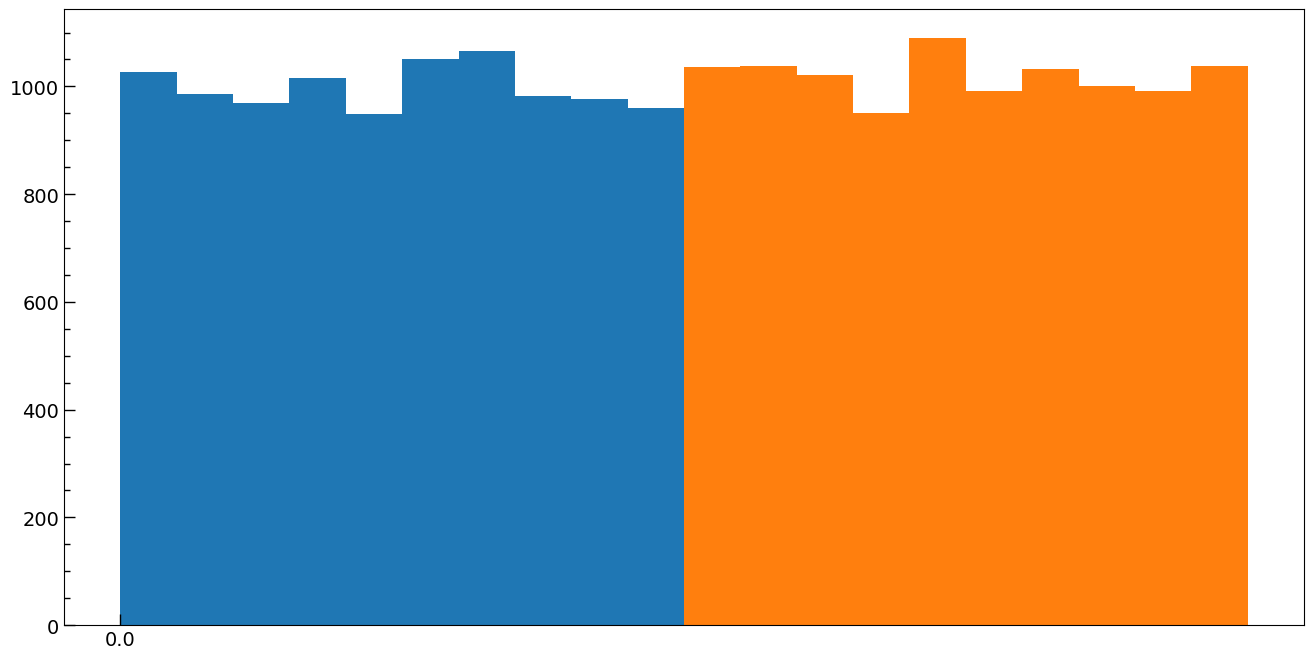

In [7]:
fig, ax = plt.subplots(figsize=(16,8))

for i in range(0,2):
    indeces = np.logical_and(unif_samples > bins[i], unif_samples < bins[i+1])
    ax.hist(unif_samples[indeces])

# ticks
set_ticks(ax, 0.2, 200)

plt.show()


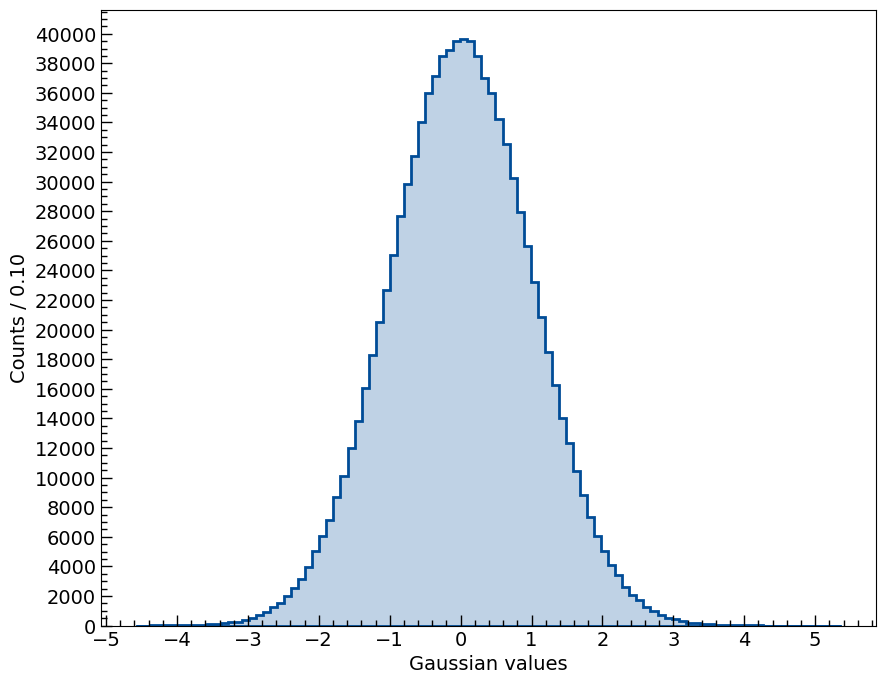

In [41]:
N = 10**6
samples = np.random.normal(0, 1, N)

fig, ax = plt.subplots(figsize=(10,8))

nbins = 100

# plot histogram
n, bins , _ = ax.hist(samples, bins=nbins, histtype='stepfilled',fc='#BFD2E5', ec = '#004C97', lw=2, alpha=1, label="Spectrum")

# array of bin centers
x = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins) - 1)])

# set Poisson uncertainty on each bin   
poisson_err =  np.sqrt(n)  

# bin width 
binwidth = bins[1] - bins[0]

# labels
ax.set_xlabel("Gaussian values", fontsize=14)
ax.set_ylabel("Counts / %1.2f" %binwidth, fontsize=14)

# ticks
set_ticks(ax, 1, 2000)

plt.show()


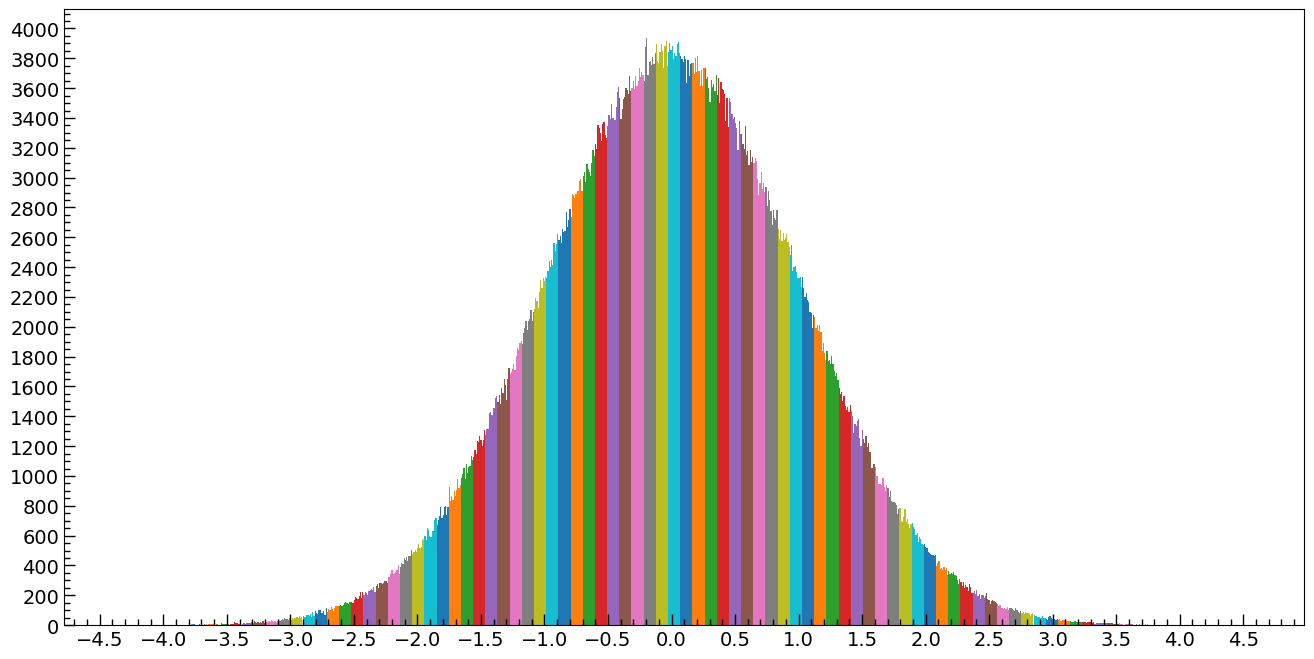

In [105]:
fig, ax = plt.subplots(figsize=(16,8))

for i in range(0,len(bins)-1):
    indeces = np.logical_and(samples > bins[i], samples < bins[i+1])
    ax.hist(samples[indeces])

# ticks
set_ticks(ax, 0.5, 200)

plt.show()


In [42]:
def generate_angular(dist, limits, N):
    
    # extremes in x direction 
    u1 = limits[0] # minimum of x sampling 
    u2 = limits[1] # maximum of x sampling 

    u = np.random.uniform(u1,u2,5*N)

    lower = 0                                       # accept-reject minimum for each point
    upper = np.max(dist(u,A)) # accept-reject maximum for each point 

    v = np.random.uniform(lower, upper, 5*N)

    # accepted points 
    points = u[v < dist(u,A)]
    # compute acceptance ratio 
    efficiency = len(points) / (5*N)

    # keep only N events if we have more 
    if len(points) >= N:
        points = points[:N]
    else:
        print('The wanted number of events is %1.0f'% N )
        print('The number of generated events is %1.0f' % len(points))

    return points, efficiency 


Efficiency: 50 %


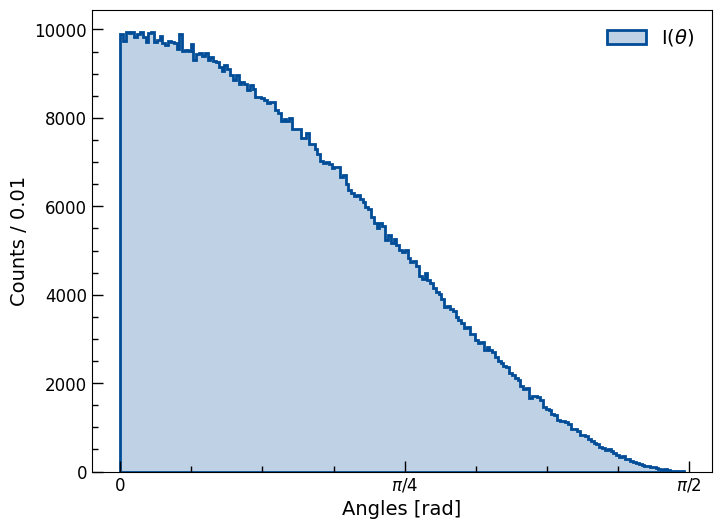

In [43]:
A = 1.

samples, eff = generate_angular(ang,(0.,0.5*np.pi), 10**6)

print('\nEfficiency: {:1.0f} %'.format(eff*100))

fig, ax = plt.subplots(figsize=(8,6))
n, bins , _ = ax.hist(samples, bins=200, histtype='stepfilled',fc='#BFD2E5', ec = '#004C97', lw=2, alpha=1, label="I$(\\theta$)")


bin_width = bins[1] - bins[0]

# ticks
ax.set_xticks([0,np.pi/4,np.pi/2],['0','$\pi/4$','$\pi/2$'])
ax.tick_params(which='major', right=False, width=1.0, length=8, direction='in', labelsize=12)
ax.tick_params(which='minor', right=False, width=1.0, length=4, direction='in', labelsize=12)
ax.xaxis.set_minor_locator(AutoMinorLocator(0.1))
ax.yaxis.set_minor_locator(AutoMinorLocator(0.25))
ax.minorticks_on()

# labels
ax.set_xlabel('Angles [rad]', fontsize=14)
ax.set_ylabel('Counts / %1.2f' % bin_width, fontsize=14)


# legend
ax.legend(loc='best', frameon=False, fontsize=14)

plt.show()

In [73]:
# constants 
tau_p = 2.1969811 # us (mu+)
tau_m = 0.8546    # us (mu-)

a_m = 0.2 * 3600 * 24 * 7 # decays in one week (assuming 0.2 Hz)
b = 6 * tau_p             # baseline starting point at 6*tau
r = 1.3                   # ratio between mu+/mu-

In [74]:
def generate_spectrum(dist,limits,N):
    
    # extremes in x direction 
    u1 = limits[0] # minimum of x sampling 
    u2 = limits[1] # maximum of x sampling 

    u = np.random.uniform(u1,u2,5*N)

    lower = 0                                       # accept-reject minimum for each point
    upper = np.max(dist(u, a_m, r, tau_p, tau_m, b)) # accept-reject maximum for each point 

    v = np.random.uniform(lower, upper, 5*N)

    # accepted points 
    points = u[v < dist(u, a_m, r, tau_p, tau_m, b)]
    # compute acceptance ratio 
    efficiency = len(points) / (5*N)

    # keep only N events if we have more 
    if len(points) >= N:
        points = points[:N]
    else:
        print('The wanted number of events is %1.0f'% N )
        print('The number of generated events is %1.0f' % len(points))

    return points, efficiency 

In [75]:
samples, eff = generate_spectrum(exp_pdf,(0.,7*tau_p),int(a_m))

print('\nEfficiency: {:1.0f} %'.format(eff*100))

The wanted number of events is 120960
The number of generated events is 63002

Efficiency: 10 %


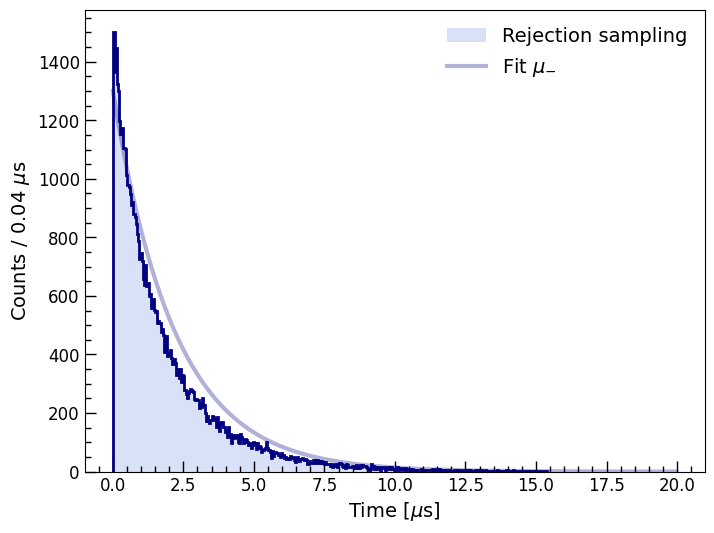

In [87]:
fig, ax = plt.subplots(figsize=(8,6))
n, bins, _ = ax.hist(samples, fc='royalblue', alpha=0.2, label='Rejection sampling', bins=400)
ax.hist(samples, histtype='step', ec='navy', lw=2, bins=400)

bin_width = bins[1] - bins[0]

# array of bin centers
x = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins) - 1)])

# set Poisson uncertainty on each bin   
poisson_err =  np.sqrt(n)  


#ax.errorbar(x, n, yerr=poisson_err, label='Bin centers', marker = 'o',markerfacecolor = 'black',
#                           markeredgecolor = 'black',markersize=5, lw = 0, ecolor='black', elinewidth=1, capsize=3)

par, cov = op.curve_fit(f = exponential, xdata = x, ydata = n, sigma = poisson_err, p0 = [1300,tau_p])


x_g = np.arange(0,20,0.02)

ax.plot(x_g, exponential(x_g, *par), color = 'navy', ls='-', alpha=0.3, lw=3, label = 'Fit $\mu_{-}$')

# ticks
ax.tick_params(which='major', right=False, width=1.0, length=8, direction='in', labelsize=12)
ax.tick_params(which='minor', right=False, width=1.0, length=4, direction='in', labelsize=12)
ax.xaxis.set_minor_locator(AutoMinorLocator(0.1))
ax.yaxis.set_minor_locator(AutoMinorLocator(0.25))
ax.minorticks_on()

# labels
ax.set_xlabel('Time [$\mu$s]', fontsize=14)
ax.set_ylabel('Counts / %1.2f $\mu$s' % bin_width, fontsize=14)

# legend
ax.legend(loc=0, frameon=False, fontsize=14)

plt.show()

/usr/local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:803: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/usr/local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


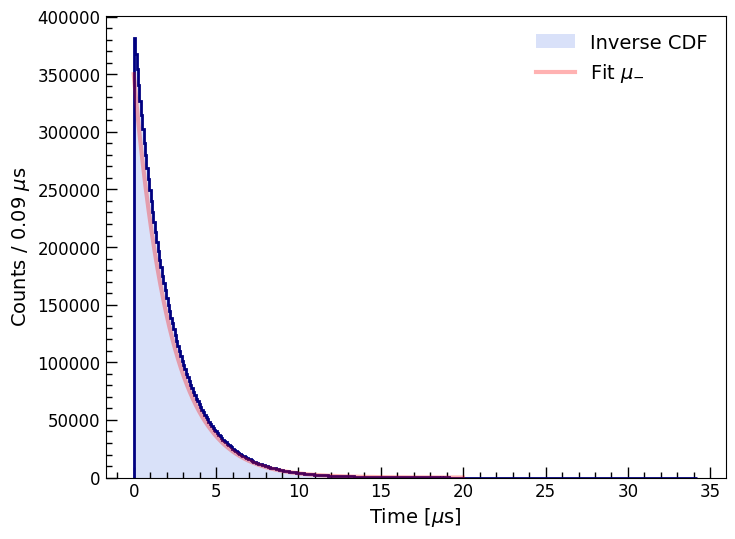

In [89]:
# Compute inverse CDF of g(theta*) by interpolation 

num_samples = N
unif_samples = np.random.uniform(size=num_samples)
samples_sorted = np.sort(unif_samples)


fig, ax = plt.subplots(figsize=(8,6))

n, bins, _ = ax.hist(inv_cdf(unif_samples, tau_p), fc='royalblue', alpha=0.2, label='Inverse CDF', bins=400)
ax.hist(inv_cdf(unif_samples, tau_p), histtype='step', ec='navy', lw=2, bins=400)

# array of bin centers
x = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins) - 1)])

# set Poisson uncertainty on each bin   
poisson_err =  np.sqrt(n)  


#ax.errorbar(x, n, yerr=poisson_err, label='Bin centers', marker = 'o',markerfacecolor = 'black',
#                           markeredgecolor = 'black',markersize=5, lw = 0, ecolor='black', elinewidth=1, capsize=3)

par, cov = op.curve_fit(f = exponential, xdata = x, ydata = n, sigma = poisson_err, p0 = [350000,tau_p])


x_g = np.arange(0,20,0.02)

ax.plot(x_g, exponential(x_g, *par), color = 'red', ls='-', alpha=0.3, lw=3, label = 'Fit $\mu_{-}$')

bin_width = bins[1] - bins[0]

# ticks
ax.tick_params(which='major', right=False, width=1.0, length=8, direction='in', labelsize=12)
ax.tick_params(which='minor', right=False, width=1.0, length=4, direction='in', labelsize=12)
ax.xaxis.set_minor_locator(AutoMinorLocator(0.1))
ax.yaxis.set_minor_locator(AutoMinorLocator(0.25))
ax.minorticks_on()

# labels
ax.set_xlabel('Time [$\mu$s]', fontsize=14)
ax.set_ylabel('Counts / %1.2f $\mu$s' % bin_width, fontsize=14)

# legend
ax.legend(loc=0, frameon=False, fontsize=14)

plt.show()


In [90]:
par

array([3.5000000e+05, 2.1969811e+00])

In [78]:
def exponential(x, a, tau):
    return a * np.exp(- x / tau)
    

In [53]:
N = 10**7

x0 = np.random.uniform(0,182, size = N)
y0 = np.random.uniform(0,20, size = N)
phi = np.random.uniform(0,2*np.pi, size = N)

def generate_theta(dist,limits,N):
    
    # extremes in x direction 
    u1 = limits[0] # minimum of x sampling 
    u2 = limits[1] # maximum of x sampling 

    u = np.random.uniform(u1,u2,5*N)

    lower = 0               # accept-reject minimum for each point
    upper = np.max(dist(u)) # accept-reject maximum for each point 

    v = np.random.uniform(lower, upper, 5*N)

    # accepted points 
    points = u[v < dist(u)]
    # compute acceptance ratio 
    efficiency = len(points) / (5*N)


    print(efficiency)
    # keep only N events if we have more 
    if len(points) >= N:
        points = points[:N]
    else:
        print('The wanted number of events is %1.0f'% N )
        print('The number of generated events is %1.0f' % len(points))

    return points, efficiency 


theta, efficiency = generate_theta(angular, (0,np.pi/2), N)

0.48998426


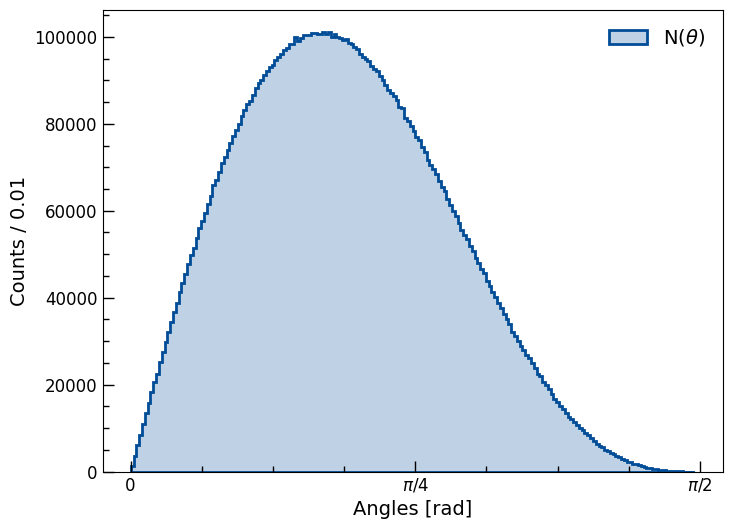

In [152]:
fig, ax = plt.subplots(figsize=(8,6))
n, bins , _ = ax.hist(theta, bins=200, histtype='stepfilled',fc='#BFD2E5', ec = '#004C97', lw=2, alpha=1, label="N$(\\theta$)")

bin_width = bins[1] - bins[0]

# ticks
ax.set_xticks([0,np.pi/4,np.pi/2],['0','$\pi/4$','$\pi/2$'])
ax.tick_params(which='major', right=False, width=1.0, length=8, direction='in', labelsize=12)
ax.tick_params(which='minor', right=False, width=1.0, length=4, direction='in', labelsize=12)
ax.xaxis.set_minor_locator(AutoMinorLocator(0.1))
ax.yaxis.set_minor_locator(AutoMinorLocator(0.25))
ax.minorticks_on()

# labels
ax.set_xlabel('Angles [rad]', fontsize=14)
ax.set_ylabel('Counts / %1.2f' % bin_width, fontsize=14)


# legend
ax.legend(loc='best', frameon=False, fontsize=14)

plt.show()

In [54]:
N = 10**7
theta, efficiency = generate_theta(angular, (0,np.pi/2), N)

0.49006998


In [55]:
def generate_xy(theta, N, h=8.):

    x0 = np.random.uniform(0,182, size = N)
    y0 = np.random.uniform(0,20, size = N)
    phi = np.random.uniform(0,2*np.pi, size = N)
    
    
    x_ = x0 - (h/np.cos(theta)) * np.sin(theta)*np.cos(phi)
    y_ = y0 - (h/np.cos(theta)) * np.sin(theta)*np.sin(phi)


    y_select =  np.logical_and(y_ > 0, y_ < 20)
    x_select = np.logical_and(x_ > 0, x_ < 182)
    mask = np.logical_and(x_select,y_select)

    x = x_[mask]
    y = y_[mask]

    n_coincidences = 100 * len(x)/N 

    return x0,y0,x_,y_, x,y, n_coincidences


In [57]:
x0,y0,x_all,y_all,x_coinc,y_coinc, coinc= generate_xy(theta, N)

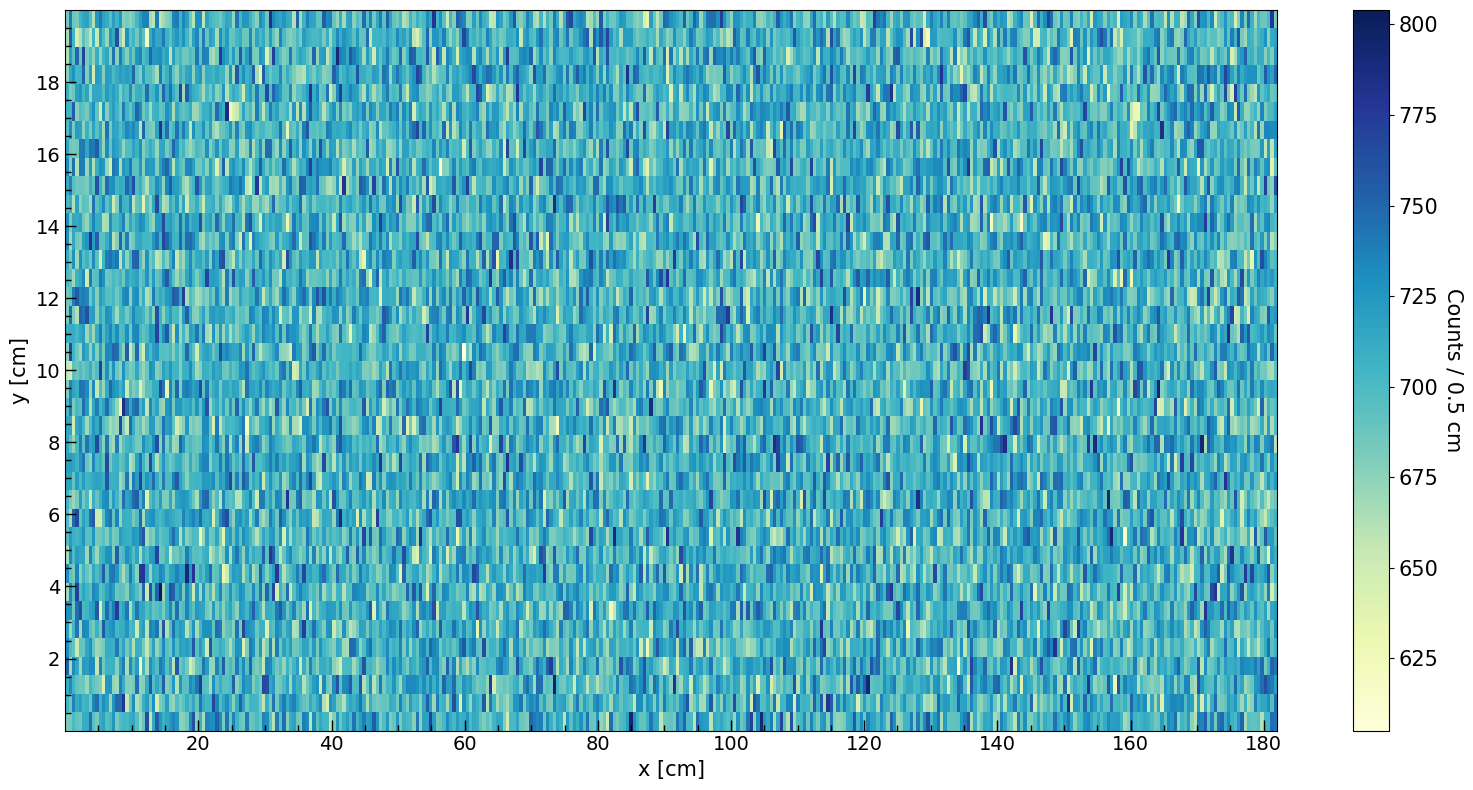

In [64]:
fig, ax = plt.subplots(figsize=(16,8))

binwidth = 0.50      # [cm]
nbinsx = int((np.max(x0) - np.min(x0))/binwidth)
nbinsy = int((np.max(y0) - np.min(y0))/binwidth)

h, binx, biny, im = ax.hist2d(x0,y0, bins=[nbinsx,nbinsy], cmap='YlGnBu', density = False )

# ticks
set_ticks(ax,20,2)
# labels
ax.set_xlabel('x [cm]', fontsize=15)
ax.set_ylabel('y [cm]' , fontsize=15)

clb = fig.colorbar(im, ax=ax)

clb.ax.tick_params(labelsize=8) 
clb.ax.set_ylabel('Counts / %1.1f cm'% binwidth, fontsize = 15,rotation=270,labelpad=18)
clb.ax.tick_params(labelsize = 15)

fig.tight_layout()
plt.show()

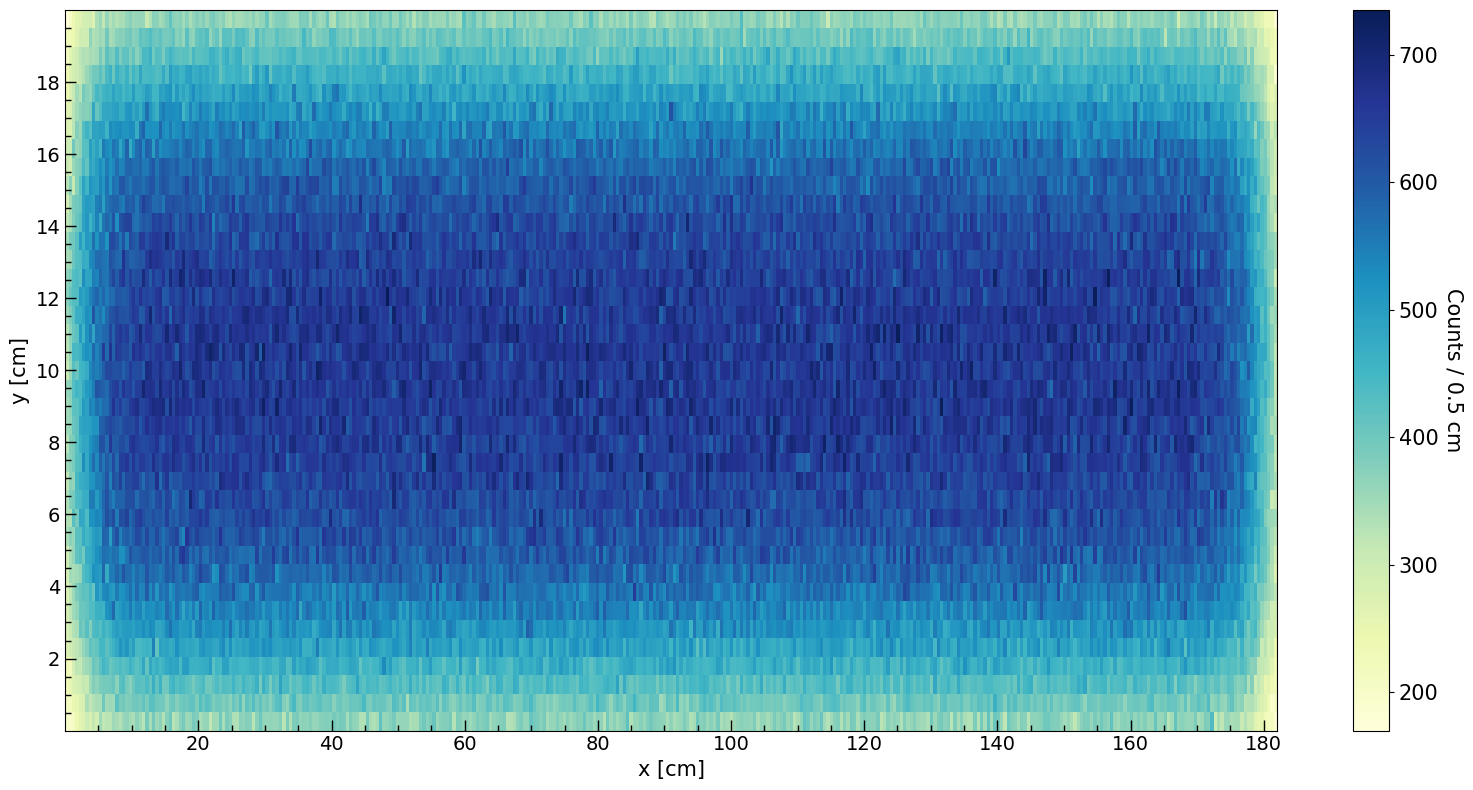

In [220]:
fig, ax = plt.subplots(figsize=(16,8))

binwidth = 0.5      # [cm]
nbinsx = int((np.max(x_coinc) - np.min(x_coinc))/binwidth)
nbinsy = int((np.max(y_coinc) - np.min(y_coinc))/binwidth)

h, binx, biny, im = ax.hist2d(x_coinc,y_coinc, bins=[nbinsx,nbinsy], cmap='YlGnBu', density = False )


# ticks
set_ticks(ax,20,2)
# labels
ax.set_xlabel('x [cm]', fontsize=15)
ax.set_ylabel('y [cm]' , fontsize=15)

clb = fig.colorbar(im, ax=ax)

clb.ax.tick_params(labelsize=8) 
clb.ax.set_ylabel('Counts / %1.1f cm'% binwidth, fontsize = 15,rotation=270,labelpad=18)
clb.ax.tick_params(labelsize = 15)

fig.tight_layout()
plt.show()


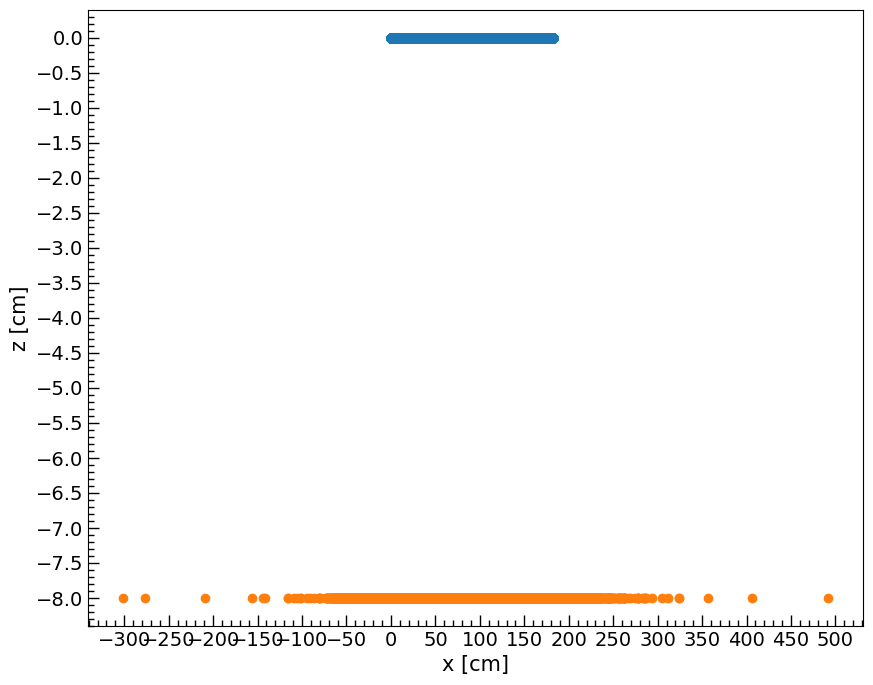

In [221]:
z0 = [0] * len(x0)
z1 = [-8.] * len(x_all)

fig, ax = plt.subplots(figsize=(10,8))

ax.plot(x0,z0, label = 'Slab 1', lw = 0, marker = 'o')
ax.plot(x_all,z1, label = 'Slab 2', lw = 0, marker = 'o')

# ticks
set_ticks(ax,50,0.5)
# labels
ax.set_xlabel('x [cm]', fontsize=15)
ax.set_ylabel('z [cm]' , fontsize=15)

plt.show()


5332426
5332426


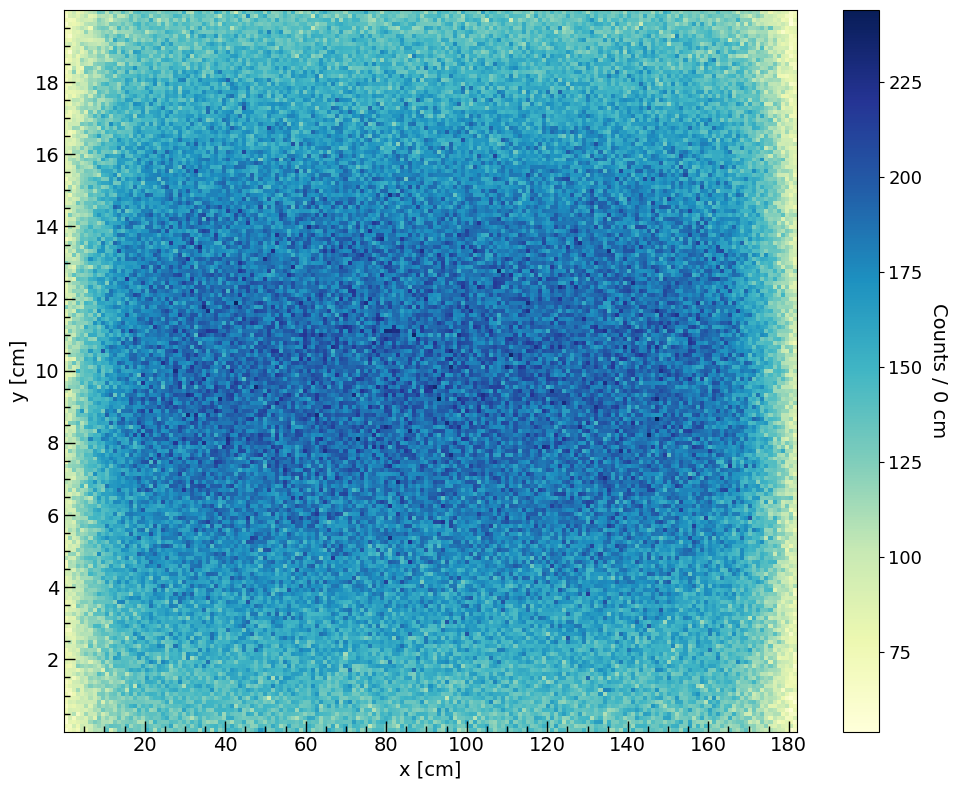

In [154]:
x,y = generate_xy(theta, N, h = 20)


fig, ax = plt.subplots(figsize=(10,8))

binwidth = 1.0      # [cm]
nbinsx = int((np.max(x0) - np.min(x0))/binwidth)
nbinsy = int((np.max(x0) - np.min(x0))/binwidth)

h, binx, biny, im = ax.hist2d(x,y, bins=[nbinsx,nbinsy], cmap='YlGnBu', density = False )


# ticks
set_ticks(ax,20,2)
# labels
ax.set_xlabel('x [cm]', fontsize=14)
ax.set_ylabel('y [cm]' , fontsize=14)

clb = fig.colorbar(im, ax=ax)

clb.ax.tick_params(labelsize=8) 
clb.ax.set_ylabel('Counts / %1.0f cm'% bin_width, fontsize = 14,rotation=270,labelpad=18)
clb.ax.tick_params(labelsize = 13)

fig.tight_layout()
plt.show()

In [70]:
# Build a dataframe with some material and corresponding properties

Material = [   'Pb',  'Plastic',    'Al' ]       # Material 
dEdX     = [   13.,     0.,       4.32]         # Energy loss in MeV/cm

# Create a dictionary with materials and properties 
dic_properties = {'Material': Material, 'dEdX': dEdX}
properties = pd.DataFrame(data=dic_properties)

In [71]:
E_i = 500 # MeV

# Layer of 15 cm Lead
E_ = E_i - properties.dEdX[0]*15.

loss = 0 

def Energy(x,x0,E0):
    loss = 0
    # Layer of plastic
    if x > 0 and x <= 2.8:
        loss = properties.dEdX[1]
    # Layer of air
    if x > 2.68 and x <= 4.34:
        loss = 0.
    # Layer of Al
    if x > 4.34 and x < 6.34:
        loss = properties.dEdX[2]
    # Layer of air
    if x > 6.34 and x <= 8:
        loss = 0.
    # Layer of plastic
    if x > 8 and x <= 10.68:
        loss = properties.dEdX[1]
    # Layer of air
    if x > 10.68 and x <= 12.34:
        loss = 0.
    # Layer of Al
    if x > 12.34 and x < 14.34:
        loss = properties.dEdX[2]
    # Layer of air
    if x > 14.34 and x <= 16:
        loss = 0.
        # Layer of plastic
    if x > 16 and x <= 18.68:
        loss = properties.dEdX[1]

    E_x = E0 - loss * (x-x0)

    return E_x

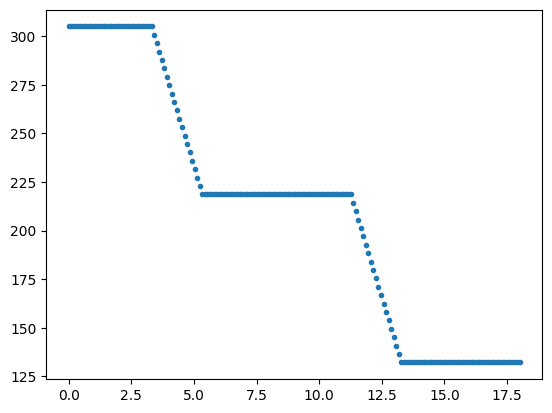

In [72]:

E = []

E_ = E_i - properties.dEdX[0]*15.

x = np.linspace(0,18,180)

for i in np.linspace(0,18,180):

    if i == 0:
        temp = E_

    e_x = Energy(i+1,i,temp)
    temp = e_x
    E.append(temp)


plt.plot(x,E, marker = '.', lw = 0)


In [284]:
len(points)

99